In [3]:
import cv2
import os
import numpy as np
from matplotlib import pyplot as plt

In [4]:
# https://jdhao.github.io/2017/11/06/resize-image-to-square-with-padding/
def resize_and_pad(image, desired_size, PADDING=False):

    old_size = image.shape[:2]  # old_size is in (height, width) format

    ratio = float(desired_size) / max(old_size)
    new_size = tuple([int(x * ratio) for x in old_size])

    # new_size should be in (width, height) format

    new_image = cv2.resize(image, (new_size[1], new_size[0]))
    left, top, right, bottom = [0, 0, 0, 0]
    if PADDING:
        delta_w = desired_size - new_size[1]
        delta_h = desired_size - new_size[0]
        top, bottom = delta_h // 2, delta_h - (delta_h // 2)
        left, right = delta_w // 2, delta_w - (delta_w // 2)

        color = [0, 0, 0]
        new_image = cv2.copyMakeBorder(
            new_image, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color
        )
    return new_image, ratio, [left, top, right, bottom]

def draw_bbox(image, bbox, class_name="", box_color=(255, 0, 0), thickness=2):
    """draw a single bounding box on the image"""
    out_image = image.copy()
    x_min, y_min, x_max, y_max = (
        int(bbox[0]),
        int(bbox[1]),
        int(bbox[2]),
        int(bbox[3]),
    )

    cv2.rectangle(
        out_image,
        (x_min, y_min),
        (x_max, y_max),
        color=box_color,
        thickness=thickness,
    )

    fontScale = 0.35
    ((text_width, text_height), _) = cv2.getTextSize(
        class_name, cv2.FONT_HERSHEY_SIMPLEX, 1.1 * fontScale, 1
    )
    cv2.rectangle(
        out_image,
        (x_min, y_min - int(text_height)),
        (x_min + text_width, y_min),
        box_color,
        -1,
    )
    cv2.putText(
        out_image,
        text=class_name,
        org=(x_min, y_min - int(0.3 * text_height)),
        fontFace=cv2.FONT_HERSHEY_SIMPLEX,
        fontScale=fontScale,
        color=(255, 255, 255),
        lineType=cv2.LINE_AA,
    )
    return out_image

def draw_bbox_form_contour(
    image,
    contour,
    rectangle_color=(0, 255, 0),
    rectangle_thickness=5,
    contour_color=(255, 0, 0),
    contour_thickness=2,
):
    x, y, w, h = cv2.boundingRect(contour)
    output_image = cv2.rectangle(
        image.copy(),
        (x, y),
        (x + w, y + h),
        rectangle_color,
        rectangle_thickness,
    )

    cv2.drawContours(output_image, [contour], -1, contour_color, contour_thickness)
    return output_image

def draw_and_crop_to_bbox(image, contour,  contour_color=(255, 0, 0), contour_thickness=2):
    # Get bounding rectangle coordinates
    x, y, w, h = cv2.boundingRect(contour)

    # Check for valid contour (avoid errors for empty contours)
    if w <= 0 or h <= 0:
        return None
    
    original_image = image.copy()

    cv2.drawContours(original_image, [contour], -1, contour_color, contour_thickness)
    
    cropped_image = original_image[y:y + h, x:x + w]
    output_image = cropped_image.copy()

    # Return the cropped image with (optional) green rectangle
    return output_image

def display_image(image, window_name, FULL_SCREEN=False):

    if FULL_SCREEN:
        cv2.namedWindow(window_name, cv2.WND_PROP_FULLSCREEN)
        cv2.setWindowProperty(
            window_name, cv2.WND_PROP_FULLSCREEN, cv2.WINDOW_FULLSCREEN
        )
    else:
        cv2.namedWindow(window_name)
    cv2.imshow(window_name, image)

def plt_display_image(image, title="", colormap="viridis", figsize=(15, 15)):
    plt.figure(figsize=figsize)
    plt.imshow(image, cmap=colormap)
    plt.title(title)
    plt.xticks([]), plt.yticks([])
    plt.show()

# https://stackoverflow.com/questions/32609098/how-to-fast-change-image-brightness-with-python-opencv/50757596
def change_brightness(image, alpha, beta):
    return cv2.addWeighted(
        image, alpha, np.zeros(image.shape, image.dtype), 0, beta
    )

def fix_illumination(image):
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    if hsv[..., 2].mean() < 50:
        alpha = int(75 / hsv[..., 2].mean())
        eq_image = change_brightness(image, alpha, 0)

    elif hsv[..., 2].mean() > 125:
        alpha = 0.7
        eq_image = change_brightness(image, alpha, -25)

    else:
        eq_image = image.copy()
    return eq_image

def find_eye_area(image):
    image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, threshold_image = cv2.threshold(image_gray, 10, 255, cv2.THRESH_BINARY)
    kernel = np.ones((10, 10), np.uint8)
    threshold_image = cv2.morphologyEx(
        threshold_image, cv2.MORPH_OPEN, kernel, iterations=5
    )
    (r, c) = np.where(threshold_image > 10)

    min_row, min_col = np.min(r), np.min(c)
    max_row, max_col = np.max(r), np.max(c)

    width = max_col - min_col
    height = max_row - min_row

    if min_row == 0:
        height += min_col * 2

    eye_area = height * width
    return eye_area

def crop_eye_area(image, pad_x=0, pad_y=0):
    image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, threshold_image = cv2.threshold(image_gray, 10, 255, cv2.THRESH_BINARY)
    kernel = np.ones((10, 10), np.uint8)
    threshold_image = cv2.morphologyEx(
        threshold_image, cv2.MORPH_OPEN, kernel, iterations=5
    )
    (r, c) = np.where(threshold_image > 10)
    min_row, min_col = np.min(r), np.min(c)
    max_row, max_col = np.max(r), np.max(c)

    cropped_image = image.copy()
    cropped_image = cropped_image[
        min_row + pad_y : max_row - pad_y, min_col + pad_x : max_col - pad_x
    ]

    return cropped_image

In [5]:
def find_optic_disc_mask(rgb_image, threshold):

    image = rgb_image.copy()
    blur_image = cv2.GaussianBlur(image,(25,25),0)
    red_blur_image = blur_image[:,:,0]

    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    clahe_equalized_image = clahe.apply(red_blur_image)
    
    ret, thresh_blur = cv2.threshold(clahe_equalized_image, threshold, 255, cv2.THRESH_BINARY)
    
    kernel = np.ones((5,5), np.uint8)
    opening = cv2.morphologyEx(thresh_blur, cv2.MORPH_OPEN, kernel, iterations = 5)

    contours, hierarchy = cv2.findContours(opening, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    shapes = []

    # out_image = image_rgb.copy()
    out_image = np.zeros(rgb_image.shape, dtype=np.uint8)
    
    for i in range(len(contours)):
        hull = cv2.convexHull(contours[i])
        area = cv2.contourArea(hull)
        x,y,w,h = cv2.boundingRect(hull)
        r = min(w,h)/2
        ideal_area = np.pi*r*r#*(w/2)*(h/2)

        if area/ideal_area >= 0.9:
            shapes.append([hull, area])
    shapes = sorted(shapes,key=lambda l:l[1], reverse=True)
    final_mask = shapes[0]
    return final_mask

In [6]:
def find_ROI(image):
    blur_image = cv2.GaussianBlur(image,(25,25),0)
    red_blur_image = blur_image[:,:,1]

    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    clahe_equalized_image = clahe.apply(red_blur_image)
    delta = 0
    for i in range(10):

        ret, thresh_blur = cv2.threshold(clahe_equalized_image, 250-delta, 255, cv2.THRESH_BINARY)

        kernel = np.ones((10,10), np.uint8)
        thresh_blur = cv2.morphologyEx(thresh_blur, cv2.MORPH_DILATE, kernel, iterations = 5)

        contours, hierarchy = cv2.findContours(thresh_blur, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
        if len(contours) == 0:
            delta +=5
        else:
            break

    return contours

In [7]:
# https://www.geeksforgeeks.org/python-opencv-find-center-of-contour/
def extract_center(contour):
    M = cv2.moments(contour)
    cx = int(M['m10']/M['m00'])
    cy = int(M['m01']/M['m00'])
    return cx, cy

In [8]:
def find_optic_disc_from_red_channel(eq_image, roi_x, roi_y, d, eye_area):
    delta = 0
    is_it_inside = True
    final_mask = None
    mask = None
    threshold = 190 #int(cropped_image[:,:,0].mean())
    old_threshold = threshold
    delta = 0
    for i in range(25):
        try:
            mask = find_optic_disc_mask(eq_image, threshold)
        except:
            threshold -= 10
            continue
        cx, cy = extract_center(mask[0])
        if roi_x-d<=cx<=roi_x+d and roi_y-d<=cy<=roi_y+d:
            is_it_inside = True
            old_threshold = threshold
        else:

            is_it_inside = False
            threshold = old_threshold + np.random.randint(-25,25)
            threshold = min(threshold, 254)
            threshold = max(threshold, 75)
            continue
        mask_area =  mask[1]
        _, radius = cv2.minEnclosingCircle(mask[0])
    #     mask_area = 3.14159 * radius**2
        area_ratio = mask_area/eye_area

        if 0.014 - delta <= area_ratio <= 0.025 + delta:
            final_mask = mask
            break
        elif area_ratio > 0.025:
            threshold_delta = 20 + np.random.randint(-15,15)
            threshold += threshold_delta
            threshold = min(threshold, 254)

        elif  area_ratio < 0.014:
            threshold_delta = -20 + np.random.randint(-15,15)
            threshold +=  threshold_delta
            threshold = max(threshold, 75)
        if i> 4 and is_it_inside:
            delta += 0.0005
    return final_mask

In [9]:
def extract_optic_disc(image_path, outout_dir_path):
    
    
    bgr_image = cv2.imread(image_path)
    rgb_image = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2RGB)
    
    eye_area = find_eye_area(rgb_image)
    cropped_image = crop_eye_area(rgb_image)
    eq_image = fix_illumination(cropped_image)

    
    height, width = eq_image.shape[:2]
    d = int(0.075*(height+width))//2
        
    roi_contours = find_ROI(eq_image)

    if len(roi_contours)==1:
        roi_x, roi_y = extract_center(roi_contours[0])
        
        final_mask = find_optic_disc_from_red_channel(eq_image, roi_x, roi_y, d, eye_area) 

        if final_mask:
            
            image_name = os.path.basename(image_path)
            #bbox_image = image_stuff.draw_bbox_form_contour(eq_image, final_mask[0])
            bbox_image = draw_and_crop_to_bbox(eq_image, final_mask[0])
            roi_image = cv2.cvtColor(bbox_image ,cv2.COLOR_RGB2BGR)
            cv2.imshow("Image with Bounding Box", roi_image)
            # Wait for a key press to close the window
            cv2.waitKey(0)
            # Close all windows
            cv2.destroyAllWindows()
            #cv2.imwrite(os.path.join(outout_dir_path,f"{image_name[:-4]}_bbox.jpg"), cv2.cvtColor(bbox_image, cv2.COLOR_RGB2BGR))
            #cv2.imwrite(os.path.join(outout_dir_path,f"{image_name[:-4]}.jpg"), cv2.cvtColor(eq_image, cv2.COLOR_RGB2BGR))

            x,y,w,h = cv2.boundingRect(final_mask[0])
            coordinates = [x, y, x+w, y+h]
            with open(os.path.join(outout_dir_path, f"{image_name[:-4]}.txt"), "w") as f:
                for coordinate in coordinates:
                    f.write(f"{int(coordinate)}\n")

In [10]:
dataset_dir_path = "assets/dataset/ORIGA/ORIGA/Training/glaucoma"
images_path = [os.path.join(dataset_dir_path,f) for f in sorted(os.listdir(f'{dataset_dir_path}'))]
print(f"Total number of images: {len(images_path)}")

Total number of images: 134


In [11]:
outout_dir_path = "threshold_output_test"
if not os.path.exists(outout_dir_path):
    os.mkdir(outout_dir_path)

In [12]:
image = "assets/dataset/DRISHTI-GS/DRISHTI-GS/Training/glaucoma/drishtiGS_060.png"
extract_optic_disc(image, outout_dir_path)

NEW APPROACH

In [131]:
import os
import pandas as pd

def create_dataframe_from_directory(directory, cvs_file):
    # List to store the file paths and labels
    data = []

    # Iterate over the subdirectories 0 and 1
    for label, subdir in enumerate(["0", "1"]):
        # Get the full path of the current subdirectory
        subdir_path = os.path.join(directory, subdir)
        # Iterate over the files in the subdirectory
        for filename in os.listdir(subdir_path):
            # Check if the file has a .png extension
            if filename.endswith(".png"):
                # Create the full path of the file
                file_path = os.path.join(subdir_path, filename)
                # Append the file path and label to the list
                data.append((file_path, label))

    # Create a DataFrame from the list of file paths and labels
    df = pd.DataFrame(data, columns=["file_path", "label"])
    
    # Save the DataFrame to a CSV file
    df.to_csv(cvs_file, index=False)
    
    return df

In [132]:
# Example usage:
train_dir = "assets/dataset/glaucoma/train"
val_dir = "assets/dataset/glaucoma/val"
test_dir = "assets/dataset/glaucoma/test"

df_train = create_dataframe_from_directory(train_dir, "train.csv")
df_val = create_dataframe_from_directory(val_dir, "val.csv")
df_test = create_dataframe_from_directory(test_dir, "test.csv")

In [133]:
df_train.label.value_counts()

label
0    5293
1    3328
Name: count, dtype: int64

In [134]:
df_train.head()

,file_path,label
0,assets/dataset/glaucoma/train\0\BEH-172.png,0
1,assets/dataset/glaucoma/train\0\BEH-174.png,0
2,assets/dataset/glaucoma/train\0\BEH-175.png,0
3,assets/dataset/glaucoma/train\0\BEH-176.png,0
4,assets/dataset/glaucoma/train\0\BEH-178.png,0


In [137]:
import cv2
import numpy as np
import os
import pandas as pd

def extract_rois_and_labels(df, output_dir, cropped_dir):
    # Create the output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    os.makedirs(cropped_dir, exist_ok=True)
    
    # Initialize an empty list to store the rows of the DataFrame
    roi_rows = []
    
    for index, row in df.iterrows():
        
        if row['label'] == 0:
            cropped_dir_roi = os.path.join(cropped_dir, '0')
            os.makedirs(cropped_dir_roi, exist_ok=True)
            output_dir_roi = os.path.join(output_dir, '0')
            os.makedirs(output_dir_roi, exist_ok=True)
        
        elif row['label'] == 1:
            cropped_dir_roi = os.path.join(cropped_dir, '1')
            os.makedirs(cropped_dir_roi, exist_ok=True)
            output_dir_roi = os.path.join(output_dir, '1')
            os.makedirs(output_dir_roi, exist_ok=True)
            
        # Load the image
        image = cv2.imread(row['file_path'])
        
        # Resize the image to 512x512
        resized_image = cv2.resize(image, (512, 512))
        
        # Convert the resized image to grayscale
        gray_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)
        
        # Apply Gaussian blur
        blurred_image = cv2.GaussianBlur(gray_image, (65, 65), 0)
        
        # Find the pixel with the highest intensity value
        max_intensity_pixel = np.unravel_index(np.argmax(blurred_image), blurred_image.shape)
        
        # Define the radius for the circle
        radius = 200 // 2
        
        # Get the x and y coordinates for cropping the image
        x = max_intensity_pixel[1] - radius
        y = max_intensity_pixel[0] - radius
        
        # Check if the cropping dimensions are valid
        if x < 0:
            x = 0
        if y < 0:
            y = 0
        if x + 2*radius > resized_image.shape[1]:
            x = resized_image.shape[1] - radius
        if y + 2*radius > resized_image.shape[0]:
            y = resized_image.shape[0] - radius
        
        # Crop the image based on the circle's center and radius
        cropped_image = resized_image[y:y+2*radius, x:x+2*radius]
        
        # Split the green channel
        green_channel = cropped_image[:, :, 1]
        # Apply histogram equalization
        clahe_op = cv2.createCLAHE(clipLimit=2)
        cropped_image = clahe_op.apply(green_channel)
        
        resized_cropped_image = cv2.resize(cropped_image, (200, 200))
        
        cropped_filename = os.path.basename(row['file_path']).split('.')[0] + '_cropped_roi.jpg'
        cropped_path = os.path.join(cropped_dir_roi, cropped_filename)
        cv2.imwrite(cropped_path, resized_cropped_image)
        
        # Create a mask for the circle
        mask = np.zeros_like(resized_image)
        cv2.circle(mask, (x + radius, y + radius), radius, (255, 255, 255), -1)
        
        # Apply the mask to the resized image
        roi_image = cv2.bitwise_and(resized_image, mask)
        
        # Split the green channel
        green_channel = roi_image[:, :, 1]
        # Apply histogram equalization
        clahe_op = cv2.createCLAHE(clipLimit=2)
        roi_image = clahe_op.apply(green_channel)
        
        # Save the ROI image
        roi_filename = os.path.basename(row['file_path']).split('.')[0] + '_roi.jpg'
        roi_path = os.path.join(output_dir_roi, roi_filename)
        cv2.imwrite(roi_path, roi_image)
        
        # Append the row to the list
        roi_rows.append({'roi_path': roi_path, 'label': row['label']})
    
    # Create a DataFrame from the list of rows
    roi_df = pd.DataFrame(roi_rows)
    
    return roi_df

In [138]:
# Extract ROIs and labels for the training images
train_roi_df = extract_rois_and_labels(df_train, 'train_roi_images/train', 'cropped_roi_images/train')
test_roi_df = extract_rois_and_labels(df_test, 'train_roi_images/test', 'cropped_roi_images/test')
val_roi_df = extract_rois_and_labels(df_val, 'train_roi_images/val', 'cropped_roi_images/val')

In [56]:
import matplotlib.pyplot as plt
import random

# Function to plot a random image from a DataFrame
def plot_random_image(df, title):
    # Get a random row from the DataFrame-
    random_row = df.sample()
    
    # Load the image
    image_path = random_row['roi_path'].values[0]
    image = cv2.imread(image_path)
    
    # Convert the image from BGR to RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Plot the image
    plt.imshow(image)
    plt.title(title)
    plt.axis('off')
    plt.show()

In [53]:
train_roi_df.head()

,roi_path,label
0,train_roi_images\BEH-172_roi.jpg,0
1,train_roi_images\BEH-174_roi.jpg,0
2,train_roi_images\BEH-175_roi.jpg,0
3,train_roi_images\BEH-176_roi.jpg,0
4,train_roi_images\BEH-178_roi.jpg,0


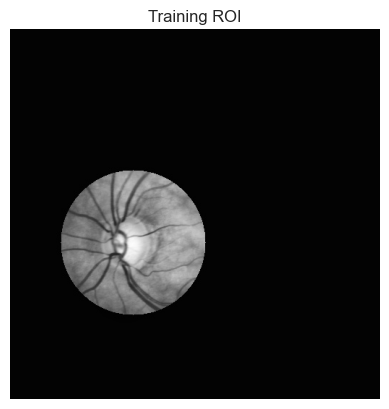

In [57]:
# Plot a random image from each DataFrame
plot_random_image(train_roi_df, 'Training ROI')